In [1]:
import awkward as ak
import vector
import hist
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import uproot

from atlas_schema.schema import NtupleSchema
from coffea import dataset_tools
from coffea.nanoevents import NanoEventsFactory

vector.register_awkward()
mplhep.style.use(mplhep.style.ATLAS1)

# getting files

In [2]:
# getting files
import atlasopenmagic

atlasopenmagic.set_release("2024r-pp")

# atlasopenmagic.available_keywords()
# atlasopenmagic.get_metadata("Pythia8EvtGen_A14NNPDF23LO_zprime3000_tt")

atlasopenmagic.get_metadata("410470")
# atlasopenmagic.get_urls("301333")

# for dsid in atlasopenmagic.available_datasets():
#     metadata = atlasopenmagic.get_metadata(dsid)
#     print(dsid, metadata["physics_short"])

Active release set to: 2024r-pp. Metadata cache cleared.
Fetching and caching all metadata for release: 2024r-pp...
Successfully cached 374 datasets.


{'dataset_number': '410470',
 'physics_short': 'PhPy8EG_A14_ttbar_hdamp258p75_nonallhad',
 'e_tag': 'e6337',
 'cross_section_pb': 729.77,
 'genFiltEff': 0.5437965,
 'kFactor': 1.139756362,
 'nEvents': 32890000,
 'sumOfWeights': 24014984445.816772,
 'sumOfWeightsSquared': 17816963736313.004,
 'process': 'ttbar',
 'generator': 'Powheg+Pythia8(v8.230)+EvtGen(v1.6.0)',
 'keywords': ['SM', 'lepton', 'top', 'ttbar'],
 'description': "POWHEG+Pythia8 ttbar production with Powheg hdamp equal 1.5*top mass, A14 tune, at least one lepton filter, ME NNPDF30 NLO, A14 NNPDF23 LO from DSID 410450 LHE files with Shower Weights added '",
 'job_path': 'https://gitlab.cern.ch/atlas-physics/pmg/infrastructure/mc15joboptions/-/tree/master/share/DSID410xxx/MC15.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.py',
 'CoMEnergy': None,
 'GenEvents': None,
 'GenTune': None,
 'PDF': None,
 'Release': None,
 'Filters': None,
 'release': {'name': '2024r-pp'}}

In [3]:
def get_xsec_norm(dsid):
    # not including normalization by sum of weights (that one depends on the number of files processed)
    lumi = 36646.74 # / pb
    meta = atlasopenmagic.get_metadata(dsid)
    return lumi * meta["cross_section_pb"] * meta["kFactor"] * meta["genFiltEff"]


fileset = {
    "Zprimett": {
        "files": {"301333.root": "reco"},  # https://cernbox.cern.ch/s/8LgmhEZsKofVxSs
        "metadata": {"meta": 0}
    },
    "ttbar": {
        "files": {"410470.root": "reco"},  # https://cernbox.cern.ch/s/maw47evOZ8QylGr
        "metadata": {"meta": 0}
    }
}

# interactive exploration

In [ ]:
events = NanoEventsFactory.from_root(fileset["ttbar"]["files"], mode="virtual", schemaclass=NtupleSchema).events()
# _ = ak.materialize(events)  # force read everything (similar to using eager mode, only use this for small inputs and testing)

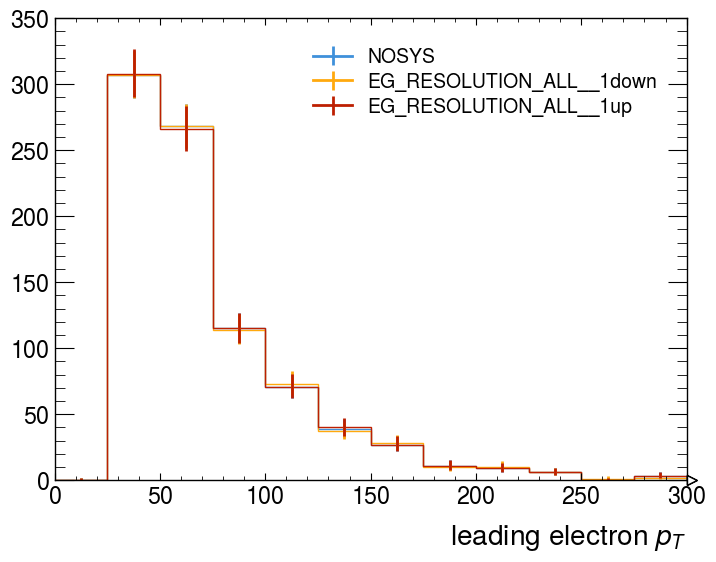

In [5]:
h = hist.new.Regular(12, 0, 300, label="leading electron $p_T$").StrCat([], name="variation", growth=True).Weight()

for variation in ["NOSYS"] + events.systematic_names[0:2]:
    # print(variation)
    event_view = events if variation == "NOSYS" else events[variation]
    h.fill(event_view.el.pt[:, 0] / 1_000, variation=variation)


fig, ax = plt.subplots()
for variation in h.axes[1]:
    h[:, variation].plot(histtype="step", label=variation, ax=ax)
ax.legend()

In [6]:
# with uproot, manually
f = uproot.open(fileset["ttbar"]["files"])
arr = f.arrays(["jet_pt_NOSYS", "jet_eta", "jet_phi", "jet_e_NOSYS", "jet_pt_JET_JER_EffectiveNP_1__1up", "jet_e_JET_JER_EffectiveNP_1__1up"])
jets = ak.zip({"pt": arr["jet_pt_NOSYS"], "eta": arr["jet_eta"], "phi": arr["jet_phi"], "energy": arr["jet_e_NOSYS"]}, with_name="PtEtaPhiECandidate")
ak.array_equal(jets.pt, events.jet.pt, check_parameters=False)

True

In [7]:
# compare systematic variation
jets_JER1 = ak.zip({"pt": arr["jet_pt_JET_JER_EffectiveNP_1__1up"], "eta": arr["jet_eta"], "phi": arr["jet_phi"], "energy": arr["jet_e_JET_JER_EffectiveNP_1__1up"]}, with_name="PtEtaPhiECandidate")
ak.array_equal(jets_JER1.pt, events["JET_JER_EffectiveNP_1__1up"].jet.pt, check_parameters=False)

True

# processor approach

In [ ]:
# coffea processor version
from coffea import processor


class Analysis(processor.ProcessorABC):
    def __init__(self):
        self.h = hist.new.Regular(12, 0, 300, label="leading jet $p_T$").\
            StrCat([], name="dsid", growth=True).StrCat([], name="variation", growth=True).\
            Weight()

    def process(self, events):
        f = uproot.open(events.metadata["filename"])
        sim_type, mc_campaign, dsid, etag = f["metadata"].axes[0]
        sumw = float(f[f"CutBookkeeper_{dsid}_284500_NOSYS"].values()[1])  # initial sum of weights
        systematics_from_hist = list(f["listOfSystematics"].axes[0])
        list_of_variations = ["NOSYS"] + events.systematic_names
        # ensure systematics in schema and in histogram match
        assert sorted(systematics_from_hist) == sorted(list_of_variations)  

        # run over subset of systematics
        for variation in ["NOSYS"] + [sys for sys in events.systematic_names if sys.startswith("JET_JER_EffectiveNP_1_")]:
            print(variation)
            event_view = events if variation == "NOSYS" else events[variation]
            self.h.fill(event_view.jet.pt[:, 0] / 1_000, dsid=dsid, variation=variation, weight=event_view.weight.mc)
        return {
            "hist": self.h,
            "meta": {
                "sumw": {dsid: {(events.metadata["fileuuid"], sumw)}}}  # sumw in set to avoid summing
        }  

    def postprocess(self, accumulator):
        # normalize histograms
        # https://topcptoolkit.docs.cern.ch/latest/starting/running_local/#sum-of-weights
        for dsid in accumulator["hist"].axes[1]:
            norm = get_xsec_norm(dsid) / sum([sumw for uuid, sumw in accumulator["meta"]["sumw"][dsid]])
            accumulator["hist"][:, dsid, :] = np.stack([accumulator["hist"][:, dsid, :].values()*norm, accumulator["hist"][:, dsid, :].variances()*norm**2], axis=-1)


run = processor.Runner(
    executor = processor.IterativeExecutor(),
    schema=NtupleSchema,
    savemetrics=True,
    chunksize=500  # tiny to simulate multiple chunks
)

samples = run.preprocess(fileset)

out, report = run(samples, processor_instance=Analysis())

out, report

In [9]:
f = uproot.open("410470.root")
arr = f["reco"].arrays(["jet_pt_JET_JER_EffectiveNP_1__1up", "jet_pt_JET_JER_EffectiveNP_1__1down", "jet_pt_NOSYS"])
arr["jet_pt_JET_JER_EffectiveNP_1__1down"] - arr["jet_pt_NOSYS"]  # this is surprisingly the same
# arr["jet_pt_JET_JER_EffectiveNP_1__1up"] - arr["jet_pt_NOSYS"]

<Array [[0, 0, 0, 0], ..., [0, 0, 0, ..., 0, 0, 0]] type='857 * var * float32'>

1 JET_JER_EffectiveNP_1_PseudoData__1down
2 JET_JER_EffectiveNP_1_PseudoData__1up
3 JET_JER_EffectiveNP_1__1down
4 JET_JER_EffectiveNP_1__1up


/var/folders/1b/0v72djfs4h18xh9fxml_1c3w0000gn/T/ipykernel_15773/1956051113.py:18: RuntimeWarning: invalid value encountered in divide
  ratio = (h[:, dsid, variation].values() / h[:, dsid, "NOSYS"].values())


(0.8, 1.2)

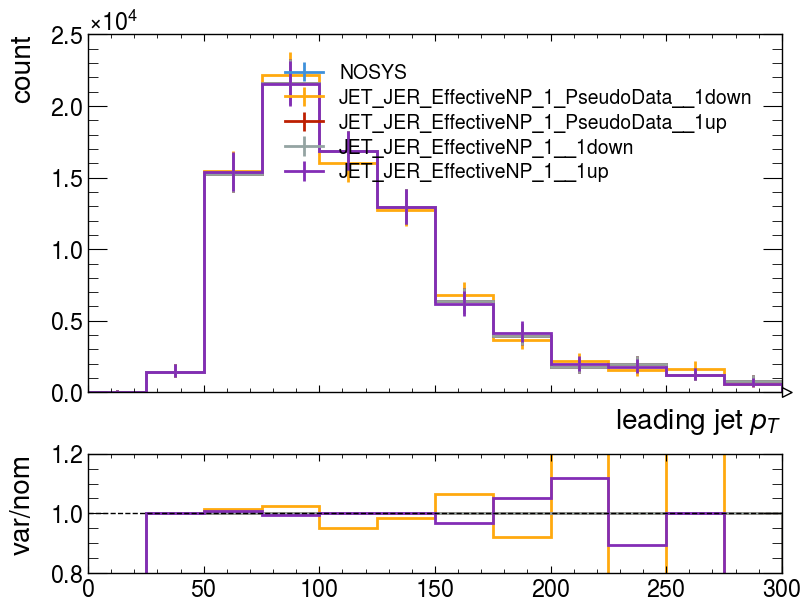

In [10]:
# note! JER systematics need to be redone to properly take into account pseudodata variations

dsid = "410470"
h = out["hist"]

fig, (ax1, ax2) = plt.subplots(nrows=2, height_ratios=(3, 1), constrained_layout=True, sharex=True)
h[:, dsid, :].plot(ax=ax1, linewidth=2)
ax1.legend()
ax1.set_ylabel("count")

edges = h[:, dsid, :].axes[0].edges
ax2.plot(edges, [1]*len(edges), color="black", linestyle="dashed", linewidth=1)
for ivar, variation in enumerate(h.axes[2]):
    if variation == "NOSYS":
        continue
    print(ivar, variation)
    # print(h[:, dsid, variation], 
    ratio = (h[:, dsid, variation].values() / h[:, dsid, "NOSYS"].values())
    ax2.stairs(ratio, edges, color=f"C{ivar}", linewidth=2)
ax2.set_ylabel("var/nom")
ax2.set_ylim([0.8, 1.2])

In [ ]:
# saving preprocessing output
import base64
import dataclasses
import json


def write_samples(samples, fname):
    # encode bytes
    serializable = []
    for s in samples:
        chunk = dataclasses.asdict(s)
        chunk["fileuuid"] = base64.b64encode(chunk["fileuuid"]).decode("ascii")
        serializable.append(chunk)
    
    with open(fname, "w") as f:
        json.dump(serializable, f)


def read_samples(fname):
    with open(fname) as f:
        samples = json.load(f)
    
    # decode bytes
    for i in range(len(samples)):
        samples[i]["fileuuid"] = base64.b64decode(samples[i]["fileuuid"])
        samples[i] = coffea.processor.executor.WorkItem(**samples[i])

    return samples


samples = run.preprocess(fileset)
write_samples(samples, "samples.json")
samples = read_samples("samples.json")

samples